<a href="https://colab.research.google.com/github/R3gm/Colab-resources/blob/main/diarization_whisper_and_pyannote_transcripts_with_speaker_names.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

audio >>> whisper transcript >>> segments pyannote >>> (srt >>> audio) (evaluation metrics)

Notes on usage:

- Make sure to [change runtime to GPU](https://www.tutorialspoint.com/google_colab/google_colab_using_free_gpu.htm). 
- The transcript will be saved in Files, which you can find in the menu on the left.
- Change the number of speakers below if different from two.
- Pick a bigger model if you want more accuracy and a smaller model if you want the program to run faster ([more info](https://github.com/openai/whisper#available-models-and-languages)).
- If you know the language being spoken is English, then change language to 'English' as this improves performance.


High level overview of what's happening here:


1.   I'm using Open AI's Whisper model to seperate audio into segments and generate transcripts.
2.   I'm then generating speaker embeddings for each segments.
3.   Then I'm using agglomerative clustering on the embeddings to identify the speaker for each segment.   

Let me know if I can make it better!


In [ ]:
# download from youtube
# !pip install -q yt-dlp
# !yt-dlp -f "best[height>=320]" https://www.youtube.com/watch?v=ll8TgCZ0plk -o video.mp4 --format mp4

# download from link
!wget http://groups.inf.ed.ac.uk/ami/AMICorpusMirror/amicorpus/ES2004a/audio/ES2004a.Mix-Headset.wav

## upload audio file   ### path = next(iter(uploaded))
# from google.colab import files
# uploaded = files.upload()


import os
directory_path = '/content'
files = os.listdir(directory_path)

# Filter out the directories and keep only the files
files = [file for file in files if os.path.isfile(os.path.join(directory_path, file))]

for file in files:
    print(file)

# file to use
path = next(iter(files))
print('use this audio: ', path)

--2023-05-03 22:00:05--  http://groups.inf.ed.ac.uk/ami/AMICorpusMirror/amicorpus/ES2004a/audio/ES2004a.Mix-Headset.wav
Resolving groups.inf.ed.ac.uk (groups.inf.ed.ac.uk)... 129.215.202.26
Connecting to groups.inf.ed.ac.uk (groups.inf.ed.ac.uk)|129.215.202.26|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://groups.inf.ed.ac.uk/ami/AMICorpusMirror/amicorpus/ES2004a/audio/ES2004a.Mix-Headset.wav [following]
--2023-05-03 22:00:06--  https://groups.inf.ed.ac.uk/ami/AMICorpusMirror/amicorpus/ES2004a/audio/ES2004a.Mix-Headset.wav
Connecting to groups.inf.ed.ac.uk (groups.inf.ed.ac.uk)|129.215.202.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33579394 (32M) [audio/x-wav]
Saving to: ‘ES2004a.Mix-Headset.wav.1’

ES2004a.Mix-Headset 100%[===================>]  32.02M  14.4MB/s    in 2.2s    

2023-05-03 22:00:08 (14.4 MB/s) - ‘ES2004a.Mix-Headset.wav.1’ saved [33579394/33579394]

ES2004a.Mix-Headset.wav
ES2004a.Mix-

# conf

* pyannote num_speakers
* languaje for whisper
* model_size of whisper

In [ ]:
num_speakers = 3 #@param {type:"integer"}

language = 'English' #@param ['any', 'English']

model_size = 'large' #@param ['tiny', 'base', 'small', 'medium', 'large']


model_name = model_size
if language == 'English' and model_size != 'large':
  model_name += '.en'


In [ ]:
!pip install -q git+https://github.com/openai/whisper.git > /dev/null
!pip install -q git+https://github.com/pyannote/pyannote-audio > /dev/null

import whisper
import datetime

import subprocess

import torch
import pyannote.audio
from pyannote.audio.pipelines.speaker_verification import PretrainedSpeakerEmbedding
embedding_model = PretrainedSpeakerEmbedding( 
    "speechbrain/spkrec-ecapa-voxceleb",
    device=torch.device("cuda"))

from pyannote.audio import Audio
from pyannote.core import Segment

import wave
import contextlib

from sklearn.cluster import AgglomerativeClustering
import numpy as np

In [ ]:
if path[-3:] != 'wav':
  subprocess.call(['ffmpeg', '-i', path, 'audio.wav', '-y'])
  path = 'audio.wav'

In [ ]:
model = whisper.load_model(model_size)

100%|█████████████████████████████████████| 2.87G/2.87G [01:03<00:00, 48.6MiB/s]


In [ ]:
result = model.transcribe(path)
segments = result["segments"]

In [ ]:
with contextlib.closing(wave.open(path,'r')) as f:
  frames = f.getnframes()
  rate = f.getframerate()
  duration = frames / float(rate)

In [ ]:
audio = Audio()

def segment_embedding(segment):
  start = segment["start"]
  # Whisper overshoots the end timestamp in the last segment
  end = min(duration, segment["end"])
  clip = Segment(start, end)
  waveform, sample_rate = audio.crop(path, clip)
  return embedding_model(waveform[None])

In [ ]:
embeddings = np.zeros(shape=(len(segments), 192))
for i, segment in enumerate(segments):
  embeddings[i] = segment_embedding(segment)

embeddings = np.nan_to_num(embeddings)

In [ ]:
clustering = AgglomerativeClustering(num_speakers).fit(embeddings)
labels = clustering.labels_
for i in range(len(segments)):
  segments[i]["speaker"] = 'SPEAKER ' + str(labels[i] + 1)

In [ ]:
def time(secs):
  return datetime.timedelta(seconds=round(secs))

f = open("transcript.txt", "w", encoding="utf-8")

for (i, segment) in enumerate(segments):
  if i == 0 or segments[i - 1]["speaker"] != segment["speaker"]:
    f.write("\n" + segment["speaker"] + ' ' + str(time(segment["start"])) + '\n')
  f.write(segment["text"][1:] + ' ')
f.close()

In [ ]:
segments[2]

{'id': 2,
 'seek': 0,
 'start': 18.0,
 'end': 21.0,
 'text': " Okay, that's fine.",
 'tokens': [51264, 1033, 11, 300, 311, 2489, 13, 51414],
 'temperature': 0.0,
 'avg_logprob': -0.42809045510213883,
 'compression_ratio': 1.2887323943661972,
 'no_speech_prob': 0.5541467666625977,
 'speaker': 'SPEAKER 1'}

In [ ]:
with open("transcript.txt", "r", encoding="utf-8") as file:
  for line in file:
    # procesar la línea aquí
    print(line)

SPEAKER 2 0:00:00

Are we, we're not allowed to dim the lights so people can see that a bit better. 

SPEAKER 1 0:00:15

Yeah. Okay, that's fine. 

SPEAKER 2 0:00:21

Am I supposed to be standing up there? 

SPEAKER 1 0:00:24

So we've got both of these clipped on. Is she going to answer me? Yeah, go. Right, both of them. Okay. Yeah. God. Actually, that's going to fall off. Okay. 

SPEAKER 2 0:01:20

Okay. Hello, everybody. I'm Sarah, project manager, and this is our first meeting. 

SPEAKER 1 0:01:30

Surprisingly, that is. 

SPEAKER 2 0:01:32

Okay, this is our agenda. We will do some stuff, get to know each other a bit better, feel more comfortable with each other. Then we'll go do tool training, talk about the project plan, discuss our own ideas and everything. And we've got 25 minutes to do that, as far as I can understand. Now, we're developing a remote control, which you probably already know. We want it to be original, something that people haven't thought of, it's not out in t

## convert to srt

In [ ]:
with open('transcript.txt', 'r', encoding="utf-8") as file:
    transcript = file.read()

In [ ]:
lines = transcript.split('\n')

In [ ]:
lines = lines[1:] ### if empty in line 1

In [ ]:
subtitles = []
subtitle_number = 1
for i in range(0, len(lines), 2):
    start_time = "00:00:00,000"
    end_time = "00:00:00,000"
    print(i)
    if i + 2 < len(lines):
        start_time = "00:" + lines[i][12:][:] + ",000"
        end_time = "00:" + lines[i+2][12:] + ",000"
        text = lines[i+1]
        subtitle = f"{subtitle_number}\n{start_time} --> {end_time}\n{text}\n\n"
        subtitles.append(subtitle)
        subtitle_number += 1
        #break


In [ ]:
with open('subtitles.srt', 'w', encoding='utf-8') as file:
    file.writelines(subtitles)
print(subtitles)

["1\n00:00:00,000 --> 00:00:15,000\nAre we, we're not allowed to dim the lights so people can see that a bit better. \n\n", "2\n00:00:15,000 --> 00:00:21,000\nYeah. Okay, that's fine. \n\n", '3\n00:00:21,000 --> 00:00:24,000\nAm I supposed to be standing up there? \n\n', "4\n00:00:24,000 --> 00:01:20,000\nSo we've got both of these clipped on. Is she going to answer me? Yeah, go. Right, both of them. Okay. Yeah. God. Actually, that's going to fall off. Okay. \n\n", "5\n00:01:20,000 --> 00:01:30,000\nOkay. Hello, everybody. I'm Sarah, project manager, and this is our first meeting. \n\n", '6\n00:01:30,000 --> 00:01:32,000\nSurprisingly, that is. \n\n', "7\n00:01:32,000 --> 00:03:04,000\nOkay, this is our agenda. We will do some stuff, get to know each other a bit better, feel more comfortable with each other. Then we'll go do tool training, talk about the project plan, discuss our own ideas and everything. And we've got 25 minutes to do that, as far as I can understand. Now, we're devel

In [ ]:
with open("subtitles.srt", "r", encoding="utf-8") as file:
  for line in file:
    # procesar la línea aquí
    print(line)

1

00:00:00,000 --> 00:00:15,000

Are we, we're not allowed to dim the lights so people can see that a bit better. 



2

00:00:15,000 --> 00:00:21,000

Yeah. Okay, that's fine. 



3

00:00:21,000 --> 00:00:24,000

Am I supposed to be standing up there? 



4

00:00:24,000 --> 00:01:20,000

So we've got both of these clipped on. Is she going to answer me? Yeah, go. Right, both of them. Okay. Yeah. God. Actually, that's going to fall off. Okay. 



5

00:01:20,000 --> 00:01:30,000

Okay. Hello, everybody. I'm Sarah, project manager, and this is our first meeting. 



6

00:01:30,000 --> 00:01:32,000

Surprisingly, that is. 



7

00:01:32,000 --> 00:03:04,000

Okay, this is our agenda. We will do some stuff, get to know each other a bit better, feel more comfortable with each other. Then we'll go do tool training, talk about the project plan, discuss our own ideas and everything. And we've got 25 minutes to do that, as far as I can understand. Now, we're developing a remote control, wh

In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

## convert to audio

In [ ]:
!pip install gTTS

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from gtts import gTTS
import os

# Open and read the SRT file
with open('subtitles.srt', 'r', encoding="utf-8") as f:
    lines = f.readlines()

# Extract the text from the subtitle file
text = ''
for i, line in enumerate(lines):
    if i % 4 == 2:  # The text is on the third line of each block
        text += line.strip() + ' '  # Add a space between each subtitle block
        print(line.strip() + ' ')

# Create a TTS object and save the audio to a file
tts = gTTS(text=text, lang='en')
tts.save('example.mp3')

# Play the audio file
os.system('example.mp3')


Are we, we're not allowed to dim the lights so people can see that a bit better. 
Yeah. Okay, that's fine. 
Am I supposed to be standing up there? 
So we've got both of these clipped on. Is she going to answer me? Yeah, go. Right, both of them. Okay. Yeah. God. Actually, that's going to fall off. Okay. 
Okay. Hello, everybody. I'm Sarah, project manager, and this is our first meeting. 
Surprisingly, that is. 
Okay, this is our agenda. We will do some stuff, get to know each other a bit better, feel more comfortable with each other. Then we'll go do tool training, talk about the project plan, discuss our own ideas and everything. And we've got 25 minutes to do that, as far as I can understand. Now, we're developing a remote control, which you probably already know. We want it to be original, something that people haven't thought of, it's not out in the shops. Trendy, appealing to a wide market, but, you know, not a hunk of metal. And user-friendly, grannies to kids, maybe even coochies 

32512

In [ ]:
from IPython.display import Audio

audio_file_path = 'example.mp3'
Audio(audio_file_path)

## original diarization for this audio

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
!wget -q http://groups.inf.ed.ac.uk/ami/AMICorpusMirror/amicorpus/ES2004a/audio/ES2004a.Mix-Headset.wav

In [ ]:
DEMO_FILE = {'uri': 'ES2004a.Mix-Headset', 'audio': 'ES2004a.Mix-Headset.wav'}

In [ ]:
!wget -q https://raw.githubusercontent.com/pyannote/AMI-diarization-setup/main/only_words/rttms/test/ES2004a.rttm

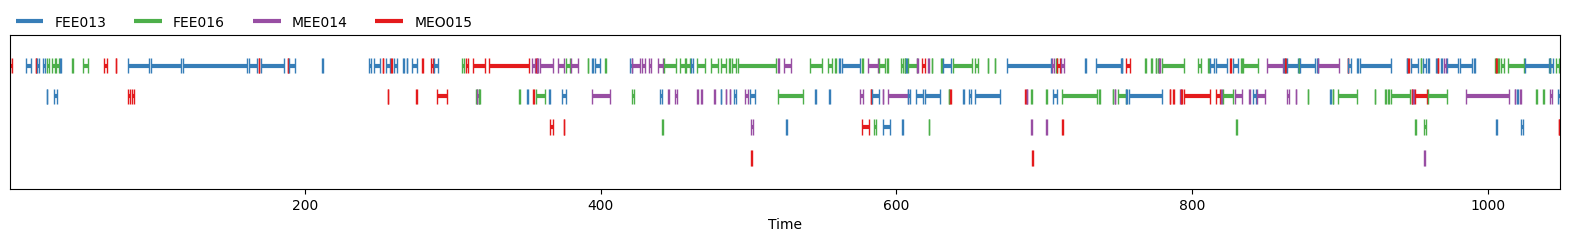

In [ ]:
# load groundtruth
from pyannote.database.util import load_rttm
_, groundtruth = load_rttm('ES2004a.rttm').popitem()

# visualize groundtruth
groundtruth # original

In [ ]:
!pip freeze | sed 's/==/==/g' | sed 's/$/,/' | tr '\n' ' ' | sed 's/ $//' | sed 's/, /\n/g' > requirements.txt

In [ ]:
#@title log_versions
%%writefile log_versions.txt
absl-py==1.4.0
aiohttp==3.8.4
aiosignal==1.3.1
alabaster==0.7.13
albumentations==1.2.1
alembic==1.10.4
altair==4.2.2
antlr4-python3-runtime==4.9.3
anyio==3.6.2
appdirs==1.4.4
argon2-cffi==21.3.0
argon2-cffi-bindings==21.2.0
arrow==1.2.3
arviz==0.15.1
asteroid-filterbanks==0.4.0
astropy==5.2.2
astunparse==1.6.3
async-timeout==4.0.2
attrs==23.1.0
audioread==3.0.0
autograd==1.5
Babel==2.12.1
backcall==0.2.0
beautifulsoup4==4.11.2
bleach==6.0.0
blessed==1.20.0
blis==0.7.9
blosc2==2.0.0
bokeh==2.4.3
branca==0.6.0
CacheControl==0.12.11
cached-property==1.5.2
cachetools==5.3.0
catalogue==2.0.8
certifi==2022.12.7
cffi==1.15.1
chardet==4.0.0
charset-normalizer==2.0.12
chex==0.1.7
click==8.1.3
cloudpickle==2.2.1
cmaes==0.9.1
cmake==3.25.2
cmdstanpy==1.1.0
colorama==0.4.6
colorcet==3.0.1
colorlog==6.7.0
colorlover==0.3.0
commonmark==0.9.1
community==1.0.0b1
confection==0.0.4
cons==0.4.5
contextlib2==0.6.0.post1
contourpy==1.0.7
convertdate==2.4.0
croniter==1.3.14
cryptography==40.0.2
cufflinks==0.17.3
cupy-cuda11x==11.0.0
cvxopt==1.3.0
cvxpy==1.3.1
cycler==0.11.0
cymem==2.0.7
Cython==0.29.34
dask==2022.12.1
datascience==0.17.6
dateutils==0.6.12
db-dtypes==1.1.1
dbus-python==1.2.16
debugpy==1.6.6
decorator==4.4.2
deepdiff==6.3.0
defusedxml==0.7.1
distributed==2022.12.1
dlib==19.24.1
dm-tree==0.1.8
docopt==0.6.2
docutils==0.16
dopamine-rl==4.0.6
duckdb==0.7.1
earthengine-api==0.1.350
easydict==1.10
ecos==2.0.12
editdistance==0.6.2
einops==0.6.1
en-core-web-sm @ https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.5.0/en_core_web_sm-3.5.0-py3-none-any.whl
entrypoints==0.4
ephem==4.1.4
et-xmlfile==1.1.0
etils==1.2.0
etuples==0.3.8
exceptiongroup==1.1.1
fastai==2.7.12
fastapi==0.88.0
fastcore==1.5.29
fastdownload==0.0.7
fastjsonschema==2.16.3
fastprogress==1.0.3
fastrlock==0.8.1
ffmpeg-python==0.2.0
filelock==3.12.0
firebase-admin==5.3.0
Flask==2.2.4
flatbuffers==23.3.3
flax==0.6.9
folium==0.14.0
fonttools==4.39.3
frozendict==2.3.7
frozenlist==1.3.3
fsspec==2023.4.0
future==0.18.3
gast==0.4.0
GDAL==3.3.2
gdown==4.6.6
gensim==4.3.1
geographiclib==2.0
geopy==2.3.0
gin-config==0.5.0
glob2==0.7
google==2.0.3
google-api-core==2.11.0
google-api-python-client==2.84.0
google-auth==2.17.3
google-auth-httplib2==0.1.0
google-auth-oauthlib==1.0.0
google-cloud-bigquery==3.9.0
google-cloud-bigquery-storage==2.19.1
google-cloud-core==2.3.2
google-cloud-datastore==2.15.1
google-cloud-firestore==2.11.0
google-cloud-language==2.9.1
google-cloud-storage==2.8.0
google-cloud-translate==3.11.1
google-colab @ file:///colabtools/dist/google-colab-1.0.0.tar.gz
google-crc32c==1.5.0
google-pasta==0.2.0
google-resumable-media==2.5.0
googleapis-common-protos==1.59.0
googledrivedownloader==0.4
graphviz==0.20.1
greenlet==2.0.2
grpcio==1.54.0
grpcio-status==1.48.2
gspread==3.4.2
gspread-dataframe==3.0.8
gTTS==2.3.2
gym==0.25.2
gym-notices==0.0.8
h11==0.14.0
h5netcdf==1.1.0
h5py==3.8.0
hijri-converter==2.3.1
holidays==0.23
holoviews==1.15.4
html5lib==1.1
httpimport==1.3.0
httplib2==0.21.0
huggingface-hub==0.14.1
humanize==4.6.0
hyperopt==0.2.7
HyperPyYAML==1.2.0
idna==3.4
imageio==2.25.1
imageio-ffmpeg==0.4.8
imagesize==1.4.1
imbalanced-learn==0.10.1
imgaug==0.4.0
importlib-resources==5.12.0
imutils==0.5.4
inflect==6.0.4
iniconfig==2.0.0
inquirer==3.1.3
intel-openmp==2023.1.0
ipykernel==5.5.6
ipython==7.34.0
ipython-genutils==0.2.0
ipython-sql==0.4.1
ipywidgets==7.7.1
itsdangerous==2.1.2
jax==0.4.8
jaxlib @ https://storage.googleapis.com/jax-releases/cuda11/jaxlib-0.4.7+cuda11.cudnn86-cp310-cp310-manylinux2014_x86_64.whl
jieba==0.42.1
Jinja2==3.1.2
joblib==1.2.0
jsonpickle==3.0.1
jsonschema==4.3.3
julius==0.2.7
jupyter-client==6.1.12
jupyter-console==6.1.0
jupyter-server==1.24.0
jupyter_core==5.3.0
jupyterlab-pygments==0.2.2
jupyterlab-widgets==3.0.7
kaggle==1.5.13
keras==2.12.0
kiwisolver==1.4.4
korean-lunar-calendar==0.3.1
langcodes==3.3.0
lazy_loader==0.2
libclang==16.0.0
librosa==0.10.0.post2
lightgbm==3.3.5
lightning==2.0.2
lightning-cloud==0.5.34
lightning-utilities==0.8.0
lit==16.0.2
llvmlite==0.39.1
locket==1.0.0
logical-unification==0.4.5
LunarCalendar==0.0.9
lxml==4.9.2
Mako==1.2.4
Markdown==3.4.3
markdown-it-py==2.2.0
MarkupSafe==2.1.2
matplotlib==3.7.1
matplotlib-inline==0.1.6
matplotlib-venn==0.11.9
mdurl==0.1.2
miniKanren==1.0.3
missingno==0.5.2
mistune==0.8.4
mizani==0.8.1
mkl==2019.0
ml-dtypes==0.1.0
mlxtend==0.14.0
more-itertools==9.1.0
moviepy==1.0.3
mpmath==1.3.0
msgpack==1.0.5
multidict==6.0.4
multipledispatch==0.6.0
multitasking==0.0.11
murmurhash==1.0.9
music21==8.1.0
natsort==8.3.1
nbclient==0.7.4
nbconvert==6.5.4
nbformat==5.8.0
nest-asyncio==1.5.6
networkx==3.1
nibabel==3.0.2
nltk==3.8.1
notebook==6.4.8
numba==0.56.4
numexpr==2.8.4
numpy==1.22.4
oauth2client==4.1.3
oauthlib==3.2.2
omegaconf==2.3.0
openai-whisper @ git+https://github.com/openai/whisper.git@c09a7ae299c4c34c5839a76380ae407e7d785914
opencv-contrib-python==4.7.0.72
opencv-python==4.7.0.72
opencv-python-headless==4.7.0.72
openpyxl==3.0.10
opt-einsum==3.3.0
optax==0.1.5
optuna==3.1.1
orbax-checkpoint==0.2.1
ordered-set==4.1.0
osqp==0.6.2.post8
packaging==23.1
palettable==3.3.3
pandas==1.5.3
pandas-datareader==0.10.0
pandas-gbq==0.17.9
pandocfilters==1.5.0
panel==0.14.4
param==1.13.0
parso==0.8.3
partd==1.4.0
pathlib==1.0.1
pathy==0.10.1
patsy==0.5.3
pep517==0.13.0
pexpect==4.8.0
pickleshare==0.7.5
Pillow==8.4.0
pip-tools==6.6.2
platformdirs==3.3.0
plotly==5.13.1
plotnine==0.10.1
pluggy==1.0.0
polars==0.17.3
pooch==1.6.0
portpicker==1.3.9
prefetch-generator==1.0.3
preshed==3.0.8
prettytable==0.7.2
primePy==1.3
proglog==0.1.10
progressbar2==4.2.0
prometheus-client==0.16.0
promise==2.3
prompt-toolkit==3.0.38
prophet==1.1.2
proto-plus==1.22.2
protobuf==3.20.3
psutil==5.9.5
psycopg2==2.9.6
ptyprocess==0.7.0
py-cpuinfo==9.0.0
py4j==0.10.9.7
pyannote.audio @ git+https://github.com/pyannote/pyannote-audio@11b56a137a578db9335efc00298f6ec1932e6317
pyannote.core==5.0.0
pyannote.database==5.0.1
pyannote.metrics==3.2.1
pyannote.pipeline==2.3
pyarrow==9.0.0
pyasn1==0.5.0
pyasn1-modules==0.3.0
pycocotools==2.0.6
pycparser==2.21
pyct==0.5.0
pydantic==1.10.7
pydata-google-auth==1.7.0
pydot==1.4.2
pydot-ng==2.0.0
pydotplus==2.0.2
PyDrive==1.3.1
pydub==0.25.1
pyerfa==2.0.0.3
pygame==2.3.0
Pygments==2.14.0
PyGObject==3.36.0
PyJWT==2.6.0
pymc==5.1.2
PyMeeus==0.5.12
pymystem3==0.2.0
PyOpenGL==3.1.6
pyparsing==3.0.9
pyrsistent==0.19.3
PySocks==1.7.1
pytensor==2.10.1
pytest==7.2.2
python-apt==0.0.0
python-dateutil==2.8.2
python-editor==1.0.4
python-louvain==0.16
python-multipart==0.0.6
python-slugify==8.0.1
python-utils==3.5.2
pytorch-lightning==2.0.2
pytorch-metric-learning==2.1.1
pytz==2022.7.1
pytz-deprecation-shim==0.1.0.post0
pyviz-comms==2.2.1
PyWavelets==1.4.1
PyYAML==6.0
pyzmq==23.2.1
qdldl==0.1.7
qudida==0.0.4
readchar==4.0.5
regex==2022.10.31
requests==2.27.1
requests-oauthlib==1.3.1
requests-unixsocket==0.2.0
rich==12.6.0
rpy2==3.5.5
rsa==4.9
ruamel.yaml==0.17.22
ruamel.yaml.clib==0.2.7
scikit-image==0.19.3
scikit-learn==1.2.2
scipy==1.10.1
scs==3.2.3
seaborn==0.12.2
semver==3.0.0
Send2Trash==1.8.0
sentencepiece==0.1.99
shapely==2.0.1
shellingham==1.5.0.post1
six==1.16.0
sklearn-pandas==2.2.0
smart-open==6.3.0
sniffio==1.3.0
snowballstemmer==2.2.0
sortedcontainers==2.4.0
soundfile==0.12.1
soupsieve==2.4.1
soxr==0.3.5
spacy==3.5.2
spacy-legacy==3.0.12
spacy-loggers==1.0.4
speechbrain==0.5.14
Sphinx==3.5.4
sphinxcontrib-applehelp==1.0.4
sphinxcontrib-devhelp==1.0.2
sphinxcontrib-htmlhelp==2.0.1
sphinxcontrib-jsmath==1.0.1
sphinxcontrib-qthelp==1.0.3
sphinxcontrib-serializinghtml==1.1.5
SQLAlchemy==2.0.10
sqlparse==0.4.4
srsly==2.4.6
starlette==0.22.0
starsessions==1.3.0
statsmodels==0.13.5
sympy==1.11.1
tables==3.8.0
tabulate==0.8.10
tblib==1.7.0
tenacity==8.2.2
tensorboard==2.12.2
tensorboard-data-server==0.7.0
tensorboard-plugin-wit==1.8.1
tensorboardX==2.6
tensorflow==2.12.0
tensorflow-datasets==4.8.3
tensorflow-estimator==2.12.0
tensorflow-gcs-config==2.12.0
tensorflow-hub==0.13.0
tensorflow-io-gcs-filesystem==0.32.0
tensorflow-metadata==1.13.1
tensorflow-probability==0.19.0
tensorstore==0.1.36
termcolor==2.3.0
terminado==0.17.1
text-unidecode==1.3
textblob==0.17.1
tf-slim==1.1.0
thinc==8.1.9
threadpoolctl==3.1.0
tifffile==2023.4.12
tiktoken==0.3.1
tinycss2==1.2.1
toml==0.10.2
tomli==2.0.1
toolz==0.12.0
torch @ https://download.pytorch.org/whl/cu118/torch-2.0.0%2Bcu118-cp310-cp310-linux_x86_64.whl
torch-audiomentations==0.11.0
torch-pitch-shift==1.2.4
torchaudio @ https://download.pytorch.org/whl/cu118/torchaudio-2.0.1%2Bcu118-cp310-cp310-linux_x86_64.whl
torchdata==0.6.0
torchmetrics==0.11.4
torchsummary==1.5.1
torchtext==0.15.1
torchvision @ https://download.pytorch.org/whl/cu118/torchvision-0.15.1%2Bcu118-cp310-cp310-linux_x86_64.whl
tornado==6.2
tqdm==4.65.0
traitlets==5.7.1
triton==2.0.0
tweepy==4.13.0
typer==0.7.0
typing_extensions==4.5.0
tzdata==2023.3
tzlocal==4.3
uritemplate==4.1.1
urllib3==1.26.15
uvicorn==0.22.0
vega-datasets==0.9.0
wasabi==1.1.1
wcwidth==0.2.6
webcolors==1.13
webencodings==0.5.1
websocket-client==1.5.1
websockets==11.0.2
Werkzeug==2.3.0
widgetsnbextension==3.6.4
wordcloud==1.8.2.2
wrapt==1.14.1
xarray==2022.12.0
xarray-einstats==0.5.1
xgboost==1.7.5
xlrd==2.0.1
yarl==1.9.2
yellowbrick==1.5
yfinance==0.2.18
zict==3.0.0
zipp==3.15.0,